In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# The path where the data is located
path = '/content/gdrive/MyDrive/ColabNotebooks/ECE 612/project 4'

In [3]:
#%%
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [4]:
Y_train_first = pd.read_pickle(os.path.join(path, 'Ytrain'))
X_train_first = pd.read_pickle(os.path.join(path,'Xtrain'))

In [5]:
print(Y_train_first.shape)
print(X_train_first.shape)

(60000, 28, 28)
(60000, 28, 28)


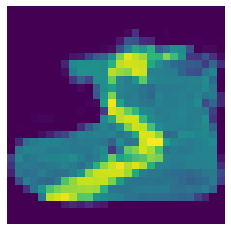

In [6]:
digit = X_train_first[0]
digit = digit.reshape(28,28)
plt.imshow(digit)
plt.axis("off")
plt.show()

In [9]:
X_train= X_train_first[:-3600]
X_valid= X_train_first[-3600:]
y_train= Y_train_first[:-3600]
y_valid= Y_train_first[-3600:]
print(X_train.shape)
print(y_train.shape)

(56400, 28, 28)
(56400, 28, 28)


In [14]:
encoder = keras.models.Sequential([
        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        keras.layers.Conv2D(12, kernel_size=3, padding="SAME", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(14, kernel_size=3, padding="SAME", activation="relu"),
])
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 12)        120       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 12)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 14)        1526      
                                                                 
Total params: 1,646
Trainable params: 1,646
Non-trainable params: 0
_________________________________________________________________


In [15]:
decoder = keras.models.Sequential([
        keras.layers.Conv2DTranspose(12, kernel_size=3, strides=2, 
                                     padding="SAME", activation="relu",input_shape=[14, 14, 14]),
        keras.layers.Conv2DTranspose(1, kernel_size=3, strides=1, 
                                     padding="SAME", activation="sigmoid"),
        keras.layers.Reshape([28, 28])
])
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 12)       1524      
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 1)        109       
 ranspose)                                                       
                                                                 
 reshape_3 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoEncoder = keras.models.Sequential([encoder, decoder])
autoEncoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 14, 14, 14)        1646      
                                                                 
 sequential_3 (Sequential)   (None, 28, 28)            1633      
                                                                 
Total params: 3,279
Trainable params: 3,279
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoEncoder.compile(loss="binary_crossentropy", optimizer="Adadelta",metrics=["binary_accuracy"])
history = autoEncoder.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1763/1763 [==============================] - 21s 5ms/step - loss: 0.6929 - binary_accuracy: 0.4828 - val_loss: 0.6884 - val_binary_accuracy: 0.6281
Epoch 2/20
1763/1763 [==============================] - 7s 4ms/step - loss: 0.6821 - binary_accuracy: 0.7172 - val_loss: 0.6738 - val_binary_accuracy: 0.7852
Epoch 3/20
1763/1763 [==============================] - 8s 5ms/step - loss: 0.6586 - binary_accuracy: 0.8006 - val_loss: 0.6356 - val_binary_accuracy: 0.8088
Epoch 4/20
1763/1763 [==============================] - 8s 5ms/step - loss: 0.5958 - binary_accuracy: 0.8087 - val_loss: 0.5479 - val_binary_accuracy: 0.8094
Epoch 5/20
1763/1763 [==============================] - 8s 4ms/step - loss: 0.5112 - binary_accuracy: 0.8088 - val_loss: 0.4698 - val_binary_accuracy: 0.8094
Epoch 6/20
1763/1763 [==============================] - 8s 5ms/step - loss: 0.4411 - binary_accuracy: 0.8088 - val_loss: 0.4080 - val_binary_accuracy: 0.8094
Epoch 7/20
1763/1763 [=============================

In [18]:
autoEncoder.save("model4.h5")

In [19]:
def plot_image(img):
    plt.imshow(img, cmap="binary")
    plt.axis("off")

def show_reconstructions(model,  images=X_valid, n=20):
    reconstruct = model.predict(images[:n])
    fig = plt.figure(figsize=(n * 1.5, 3))    
    for i in range(n):
        plt.subplot(2, n, 1 + i)
        plot_image(X_valid[i])
        plt.subplot(2, n, 1 + n + i)
        plot_image(reconstruct[i])

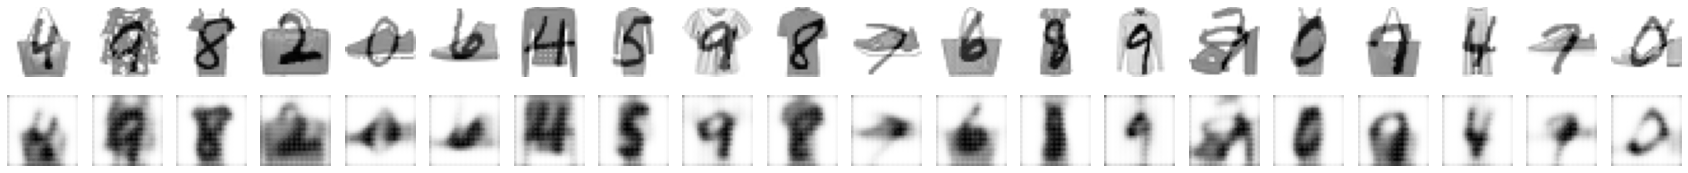

In [20]:
show_reconstructions(autoEncoder) 
plt.show()

In [21]:
denoised = autoEncoder.predict(X_valid)


In [22]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

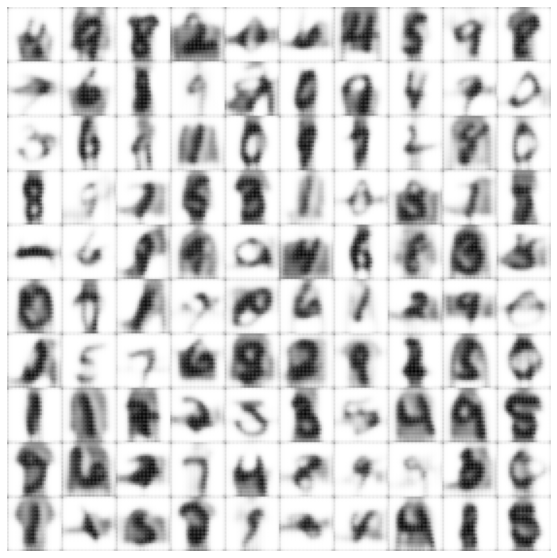

In [23]:
n = 100
plt.figure(figsize=(10,10))
example= denoised[:n]
plot_digits(example, images_per_row=10)
plt.show()

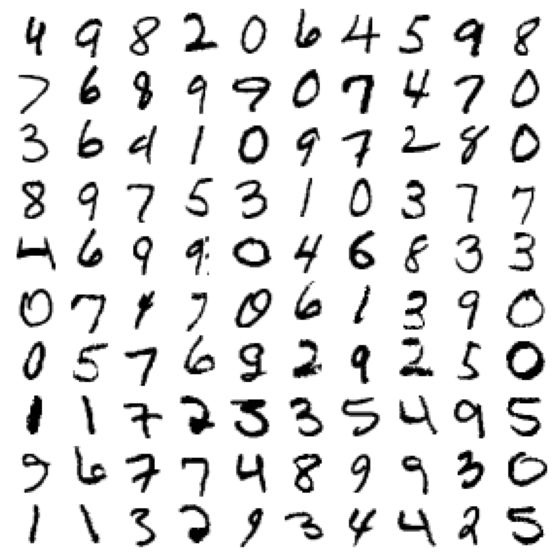

In [24]:
plt.figure(figsize=(10,10))
example = y_valid[:n]
plot_digits(example, images_per_row=10)
plt.show()

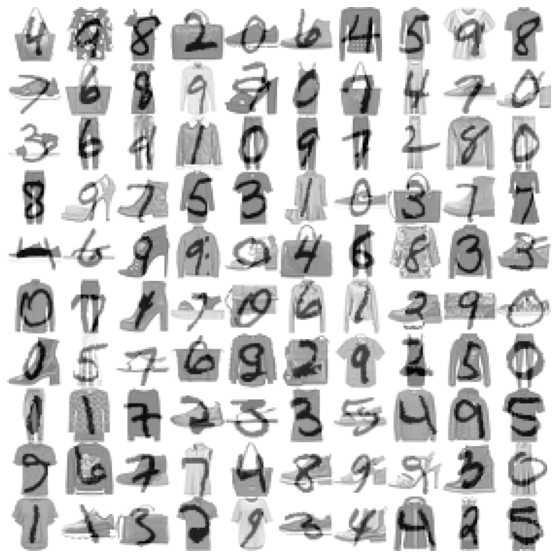

In [25]:
plt.figure(figsize=(10,10))
example = X_valid[:n]
plot_digits(example, images_per_row=10)
plt.show()